<a href="https://colab.research.google.com/github/Vaelastraszz/Image_Processing/blob/master/Projet_7_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


<h1> Récupération des images + labels </h1>

In [0]:
import os

def get_images() :
    
    img_list = []
    start_path = '/content/gdrive/My Drive/Dogs/Images/' # current directory
    
    for path,dirs,files in os.walk(start_path):
        for filename in files:
            img_list.append(os.path.join(path,filename))
    
    return img_list

Récupération de la liste des chemins de toutes les images de chiens du drive

In [0]:
import re

def get_labels(list_img):
    
    labels = []
    
    for i in range(len(list_img)):
    
        m = re.search('/content/gdrive/My Drive/Dogs/Images/(.+?)/', list_img[i])
        if m:
            found = m.group(1)
    
        labels.append(found[10:])
    
    return labels

Récupération du label de toutes les images 

In [0]:
test_list = get_images()
labels = get_labels(test_list)

Création de la liste des chemins d'images de chiens et de leur labels à chacune

<h3> Test d'affichage d'une image </h3>

In [0]:
from PIL import Image
from PIL import ImageFilter

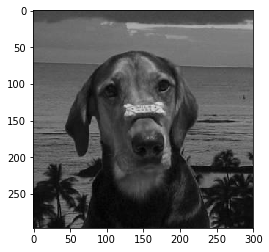

In [0]:
# Charger l'image
img = Image.open(test_list[1552]) 

img_pic = np.array(img)
# Afficher l'image chargée
plt.imshow(img_pic)
plt.show()

<h2> Resizing des images </h2>

In [0]:
def resize(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:
        # It must be fixed by width
        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:
        # Fixed by height
        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (255, 255, 255, 255))
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

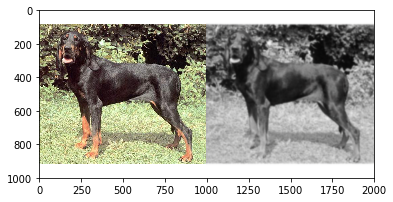

In [0]:
lap = gaussian_filter(np.array(resize(Image.open(test_list[1703]),1000,1000)), sigma=4)
ori = np.array(resize(Image.open(test_list[1703]),1000,1000))

res = np.hstack((ori,lap))

plt.imshow(res)

In [0]:
cv2.absdiff(lap,ori).shape

(1000, 1000, 3)

<h2> Création de la liste d'images en matrices puis réalisation de ZCA -> PCA + Whitening puis reconstruction </h2> 

In [0]:
x_data = np.array([np.array(resize(Image.open(test_list[i]),100,100)).reshape(1,-1) for i in range(0,1000)])

In [0]:
def chunking(list_pic):
    
    total_array = x_data
    
    #for i in range(1,int(len(list_pic)/1000)):
    for i in range(1,5):
            
        temp_array = np.array( [np.array(resize(Image.open(test_list[i]),200,200)).reshape(1,-1) for i in range(1000*i,1000*(i+1))])
        
        total_array = np.concatenate((total_array,temp_array), axis=0)
    
    
    return total_array

In [0]:
#x_data = chunking(test_list)
x_data.shape

In [0]:
x_data = x_data[:,0,:]

<h2> Normalisation des images + filtrage </h2>

<h3> Histogram Equalization </h3>

In [0]:
from sklearn.preprocessing import normalize
import cv2

In [0]:
#clahe = cv2.createCLAHE()
#x_data_norm = clahe.apply(x_data)
x_data_norm = cv2.equalizeHist(x_data) 

In [0]:
res = np.hstack((x_data[6],x_data_norm[6]))

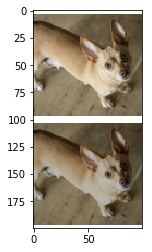

In [0]:
plt.imshow(res.reshape(200,100,-1))


<h3> Gaussian Filtering </h3>

In [0]:
from PIL import ImageFilter

In [0]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_laplace
from scipy.ndimage import laplace

In [0]:
def enhance_image(array_pic):
    
    fil_array = array_pic    
    
    for i in range(x_data_norm.shape[0]):
    
        fil_array[i] = gaussian_filter(x_data_norm[i], sigma=4)
    
    return fil_array

In [0]:
x_fil = enhance_image(x_data_norm)

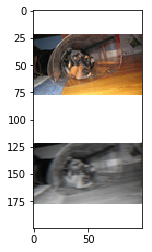

In [0]:
res2 = np.hstack((x_data[1700], x_fil[1700]))
plt.imshow(res2.reshape(200,100,-1))

Comparaison entre l'image processée et celle d'origine juste remise à une taille différente

<h3> PCA + Reconstruction </h3>

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

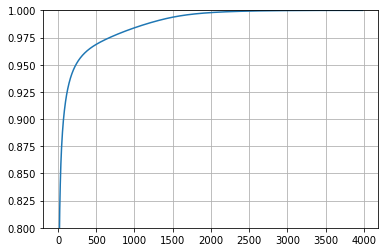

In [0]:
#Set pca to find principal components that explain 99%
#of the variation in the data
pca = PCA()

#Run PCA on normalized image data
pca.fit(x_augmented)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0.8, 1.0)
plt.grid()

In [0]:
pca = PCA(n_components = 500)

lower_dim = pca.fit_transform(x_augmented)

In [0]:
lower_dim.shape

(3982, 500)

In [0]:
approximation = pca.inverse_transform(lower_dim)

approximation.shape

(3982, 30000)

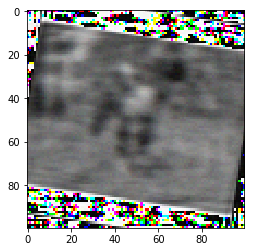

In [0]:
plt.imshow(approximation[5].reshape(100,100,-1).astype(np.uint8))

In [0]:
approximation = approximation.astype(np.uint8)

<h2> Data Augmentation </h2>




In [0]:
import skimage as sk
import random

In [0]:
def flip(im):
    
    flip_im = np.fliplr(im)
    
    return flip_im

In [0]:
def rotate(im):
    
    random_degree = random.uniform(-25, 25)
    
    return sk.transform.rotate(im, random_degree)

In [0]:
def noise(im):
    
    return sk.util.random_noise(im)

In [0]:
rot = rotate(x_fil[1].reshape(100,100,-1)).reshape(-1)

In [0]:
def create_augmented_data(list_im):
    
    augmented_data = []
    augmented_label = []
    
    # dictionary of the transformations functions we defined earlier
    available_transformations = {
    'rotate': rotate,
    'noise': noise,
    'flip' : flip
    }

    
    for i in range(len(list_im)):
        
        # random num of transformations to apply
        num_transformations_to_apply = random.randint(1, len(available_transformations))
    
        num_transformations = 0
        transformed_image = None
        
        augmented_data.append(list_im[i])
        augmented_label.append(sub_label[i])
        
        while num_transformations <= num_transformations_to_apply:
        
            augmented_label.append(sub_label[i])
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](list_im[i].reshape(100,100,-1))
            num_transformations += 1
            reshaped = transformed_image.reshape(-1)
            augmented_data.append(reshaped) 

            
    return augmented_data,augmented_label

In [0]:
x_augmented,label_aug = create_augmented_data(x_fil)

In [0]:
for i in range(len(x_augmented)):
    if x_augmented[i].dtype != np.dtype('uint8'):
        x_augmented[i] = (x_augmented[i] * 255 / np.max(x_augmented[i].reshape(100,100,-1))).astype('uint8')

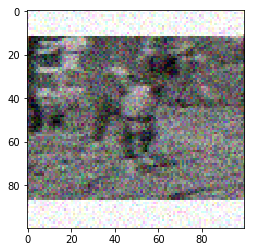

In [0]:
plt.imshow(x_augmented[5].reshape(100,100,-1))

In [0]:
len(label_aug)

3982

<h2> Texture Extraction </h2>

<h3> Global Texture </h3>

In [0]:
!pip install mahotas

     |████████████████████████████████| 1.5MB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fb/2a/81/12bc1070527dc81ef856f9d36db9ec0a42e8c14985d005395b
Successfully built mahotas


In [0]:
import mahotas as mt

In [0]:
def extract_features(image):
        
        texture = []
        
        for i in range(len(image)):
        # calculate haralick texture features for 4 types of adjacency
            
            gray = cv2.cvtColor(image[i].reshape(100,100,-1), cv2.COLOR_BGR2GRAY)
            
            textures = mt.features.haralick(gray)

            # take the mean of it and return it
            ht_mean = textures.mean(axis=0)

            texture.append(ht_mean)
        
        return texture

In [0]:
texture = extract_features(approximation)

In [0]:
for i in range(arr_deletion.shape[0]):
    texture.pop(arr_deletion[i])

In [0]:
texture[2]

array([ 2.43891026e-04,  1.15992758e+03,  9.29849734e-01,  8.28117430e+03,
        6.17783700e-02,  2.25063828e+02,  3.19647696e+04,  8.48665976e+00,
        1.28421850e+01,  7.66908626e-05,  5.82968061e+00, -3.02766611e-01,
        9.94833306e-01])

<h3> Local Texture <h3>

In [0]:
from skimage.feature import local_binary_pattern
from scipy.stats import itemfreq

In [0]:
def extract_local(image):
        
        texture = []
        
        for i in range(len(image)):
        # calculate LBP texture features
            
            gray = cv2.cvtColor(image[i].reshape(100,100,-1), cv2.COLOR_BGR2GRAY)
            
            radius = 3
            
            no_points = 8 * radius
            
            lbp = local_binary_pattern(gray, no_points, radius, method='uniform')

                # Calculate the histogram
            x = itemfreq(lbp.ravel())
            # Normalize the histogram
            hist = x[:, 1]/sum(x[:, 1])

            # Append histogram to texture

            texture.append(hist)
        
        return texture

In [0]:
local = extract_local(approximation)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


In [0]:
for i in range(arr_deletion.shape[0]):
    local.pop(arr_deletion[i])

In [0]:
local[0]

array([0.0662, 0.0396, 0.016 , 0.0159, 0.0149, 0.0157, 0.0165, 0.0174,
       0.0182, 0.0234, 0.0237, 0.0343, 0.0343, 0.0265, 0.0179, 0.02  ,
       0.014 , 0.0129, 0.0087, 0.0094, 0.01  , 0.0124, 0.0166, 0.0339,
       0.0595, 0.4221])

<H2> SIFT, SURF, ORB -> keypoints + detectors, extraction de keypoints de shape </h2> 

<h3> Initialisation de ORB et test de descripteurs sur image filtrée par un filtre de gauss sigma 4 </h3>

In [0]:
# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(x_augmented[0].reshape(100,100,-1),None)

# compute the descriptors with ORB
kp, des = orb.compute(x_augmented[0].reshape(100,100,-1), kp)

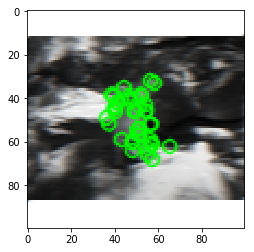

In [0]:
test = cv2.drawKeypoints(x_augmented[0].reshape(100,100,-1),kp,None,color=(0,255,0))
plt.imshow(test)

<h3> Test Sharpening </h3>

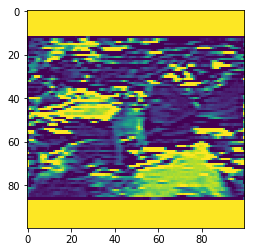

In [0]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
gray = cv2.cvtColor(x_fil[0].reshape(100,100,-1), cv2.COLOR_BGR2GRAY)
im = cv2.filter2D(gray, -1, kernel)
plt.imshow(im)


<h3> Création d'une fonction d'application d'ORB pour récupérer la matrice de descripteurs puis application au dataset </h3>

In [0]:
#sharpening filter kernel
k = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

def get_des(image):
    
    im = image.reshape(100,100,-1)
    #im = cv2.filter2D(im, -1, k)
    
    # find the keypoints with ORB
    kp = orb.detect(im,None)

    # compute the descriptors with ORB
    kp, des = orb.compute(im, kp)
            
    return des

In [0]:
def create_descriptors(im_array):
    
    list_desc = []
    
    for i in range(im_array.shape[0]):  
        
        list_desc.append(get_des(im_array[i]))
     
    return list_desc

In [0]:
orb = cv2.ORB_create()

list_desc = create_descriptors(np.array(approximation))

In [0]:
arr_deletion= []

for i in range(len(list_desc)):
    if list_desc[i] is None:
        arr_deletion.append(i)
        print (i)
        
arr_deletion = np.array(arr_deletion)

32
157
924
926
1291
1583
1882
1918
1919
2099
2100
2164
2344
2811
3590
3790


In [0]:
array_none = []
list_bis = [i for i in list_desc if i is not None]

In [0]:
full_desc = np.concatenate((list_bis))

In [0]:
full_desc.shape

(123188, 32)

<h2> KMEANS Clustering des descripteurs pour récupérer des features d'identification </h2>

In [0]:
sub_label = [i for i in labels[0:1000] if i is not None]

In [0]:
#sub_label.pop(552)
for i in range(arr_deletion.shape[0]):
    label_aug.pop(arr_deletion[i])

In [0]:
set(label_aug)

{'Afghan_hound', 'Chihuahua', 'Maltese_dog', 'Pekinese', 'Shih-Tzu'}

<h3> KMEANS Clustering </h3>

In [0]:
from sklearn import cluster, metrics

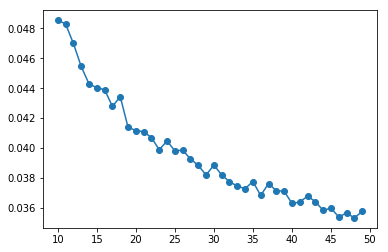

In [0]:
silhouettes = []
for num_clusters in range(10,50):
    cls=cluster.KMeans(n_clusters=num_clusters, n_init=1, init='random')
    cls.fit(full_desc)
    silh= metrics.silhouette_score(full_desc, cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(10,50),silhouettes, marker='o')

Initialisation du nb de clusters en prenant nb_espèces * 10 

In [0]:
cls=cluster.KMeans(n_clusters=50)
cls.fit(full_desc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [0]:
clusters = cls.predict(full_desc)

In [0]:
from collections import Counter, defaultdict
print(Counter(cls.labels_))

Counter({16: 3257, 46: 2970, 10: 2849, 39: 2827, 11: 2787, 23: 2722, 32: 2698, 34: 2695, 18: 2658, 31: 2653, 9: 2643, 15: 2621, 8: 2601, 13: 2582, 20: 2558, 27: 2548, 48: 2531, 0: 2529, 7: 2526, 44: 2518, 41: 2514, 43: 2512, 26: 2484, 37: 2472, 25: 2472, 22: 2429, 4: 2413, 49: 2411, 17: 2400, 45: 2357, 29: 2357, 28: 2345, 36: 2339, 35: 2325, 12: 2315, 47: 2306, 21: 2306, 40: 2271, 38: 2262, 3: 2257, 30: 2256, 1: 2243, 14: 2233, 24: 2226, 42: 2222, 19: 2216, 5: 2205, 2: 2192, 33: 2102, 6: 1973})


<h3> t-SNE </h3>

In [0]:
from sklearn.manifold import TSNE
import seaborn as sns 
import matplotlib.patheffects as PathEffects

In [0]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [0]:
tsne = TSNE(n_components=2, perplexity=40, verbose=2, n_iter=500,early_exaggeration=1)
tsne0 = tsne.fit_transform(full_desc)

(<Figure size 576x576 with 1 Axes>,
 [Text(1.4852583, 8.388342, '0'),
  Text(-13.528097, -7.647092, '1'),
  Text(1.6482481, -6.8105555, '2'),
  Text(-19.435003, -0.08724396, '3'),
  Text(-5.0722046, 10.229488, '4'),
  Text(-6.2078824, 1.1054995, '5'),
  Text(8.525667, -4.396736, '6'),
  Text(6.3603835, 9.5779085, '7'),
  Text(-4.318669, -6.794779, '8'),
  Text(5.8242526, 15.8942175, '9'),
  Text(-16.076263, -1.9965351, '10'),
  Text(5.7223654, 10.263234, '11'),
  Text(3.4314146, -6.084755, '12'),
  Text(7.730818, -1.4023539, '13'),
  Text(-6.242091, -11.291524, '14'),
  Text(-0.69163597, 5.9873924, '15'),
  Text(-2.3615556, 1.9585507, '16'),
  Text(-8.804788, -11.437629, '17'),
  Text(11.295004, 7.2658, '18'),
  Text(-0.574732, -13.168154, '19'),
  Text(-1.0741837, 16.067585, '20'),
  Text(-1.3747492, -0.8972093, '21'),
  Text(5.704293, 10.536871, '22'),
  Text(1.2692913, -4.9380913, '23'),
  Text(-0.25373808, -16.352592, '24'),
  Text(15.582356, 8.532952, '25'),
  Text(11.3314, -1.485

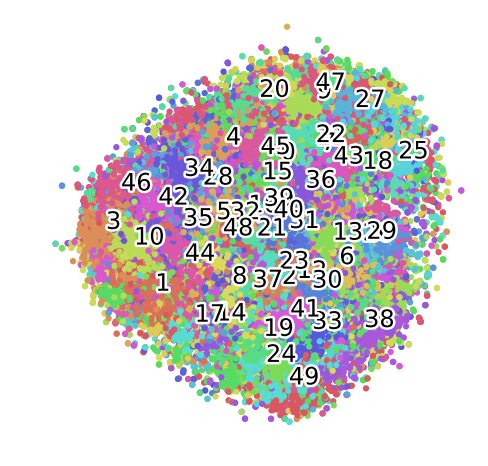

In [0]:
fashion_scatter(tsne0, clusters)

<h1> Création d'histogramme + classification </h1>

In [0]:
import collections

def create_hist(liste_pic):
    
    histo = []  
    
    for i in range(len(liste_pic)):
        
        vect = np.zeros(50)
        
        idx = cls.predict(liste_pic[i])
        dict_desc = collections.Counter(idx)
        
        for k in range(vect.shape[0]):
            
            vect[k]= dict_desc[k]
        
        histo.append(vect)
      
    return histo

In [0]:
histo_pic = create_hist(list_bis)

In [0]:
histo_pic = np.stack(histo_pic)

In [0]:
histo_pic = np.hstack((histo_pic,texture,local))

<h2> Classification </h2>

In [0]:
from sklearn import preprocessing

In [0]:
le = preprocessing.LabelEncoder()

In [0]:
le.fit(label_aug)

LabelEncoder()

In [0]:
le.classes_

array(['Afghan_hound', 'Chihuahua', 'Maltese_dog', 'Pekinese', 'Shih-Tzu'],
      dtype='<U12')

In [0]:
encoded_label = le.transform(label_aug)

<h3> SVC + Train/test/split

In [0]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(histo_pic,encoded_label,test_size = 0.2,random_state = 0, stratify=encoded_label)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

svm = LinearSVC()

params = { 'C': np.logspace(-3, 3, 7) }

gs_svm = GridSearchCV(svm, params, cv=5)
gs_svm.fit(X_train, y_train)

print(gs_svm.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 1.0}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [0]:
y_pred_svc=gs_svm.predict(X_test)
f1_score(y_test, y_pred_svc, average='micro')

0.44710327455919396

In [0]:
print(classification_report(y_test, y_pred_svc, target_names=le.classes_))

              precision    recall  f1-score   support

Afghan_hound       0.46      0.62      0.53       184
   Chihuahua       0.37      0.16      0.22       121
 Maltese_dog       0.48      0.68      0.56       203
    Pekinese       0.26      0.10      0.15       116
    Shih-Tzu       0.46      0.42      0.44       170

   micro avg       0.45      0.45      0.45       794
   macro avg       0.40      0.40      0.38       794
weighted avg       0.42      0.45      0.41       794



<h3> Reseau de neuronnes classiques MLP <h3> 

In [0]:
from sklearn.neural_network import MLPClassifier

In [0]:
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier()

param_grid = { 
    'hidden_layer_sizes' : [(50,25),(150,),(100,)],
    'batch_size' : [100, 200],
    'learning_rate' : ['constant', 'invscaling']
}

gs_mlp = GridSearchCV(mlp, param_grid, cv=3)
gs_mlp.fit(X_train, y_train)

print(gs_mlp.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

{'batch_size': 200, 'hidden_layer_sizes': (150,), 'learning_rate': 'constant'}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
y_pred_mlp=gs_mlp.predict(X_test)
f1_score(y_test, y_pred_mlp, average='micro')

0.5428211586901763

In [0]:
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))

              precision    recall  f1-score   support

Afghan_hound       0.59      0.61      0.60       184
   Chihuahua       0.46      0.46      0.46       121
 Maltese_dog       0.59      0.64      0.61       203
    Pekinese       0.40      0.35      0.38       116
    Shih-Tzu       0.58      0.54      0.56       170

   micro avg       0.54      0.54      0.54       794
   macro avg       0.52      0.52      0.52       794
weighted avg       0.54      0.54      0.54       794



<h3> Random Forests </h3>

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators' : [100, 500, 1000],
    'max_depth' : [2, 4, 6],
    'criterion' :['gini', 'entropy']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=5,scoring = 'f1_micro',n_jobs=-1)
gs_rfc.fit(X_train, y_train)

print(gs_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 500}


In [0]:
y_pred_rfc=gs_rfc.predict(X_test)
f1_score(y_test, y_pred_rfc, average='micro')

0.45717884130982367

In [0]:
print(classification_report(y_test, y_pred_rfc, target_names=le.classes_))

              precision    recall  f1-score   support

Afghan_hound       0.41      0.80      0.54       184
   Chihuahua       0.72      0.17      0.28       121
 Maltese_dog       0.44      0.66      0.53       203
    Pekinese       1.00      0.03      0.05       116
    Shih-Tzu       0.59      0.34      0.43       170

   micro avg       0.46      0.46      0.46       794
   macro avg       0.63      0.40      0.37       794
weighted avg       0.59      0.46      0.40       794



<h3> Dummy Classifier </h3>

In [0]:
from sklearn.dummy import DummyClassifier

In [0]:
dummy_biased = DummyClassifier(random_state=0)

dummy_biased.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='stratified')

In [0]:
y_pred_dummy=dummy_biased.predict(X_test)

In [0]:
f1_score(y_test, y_pred_dummy, average='micro')

0.20599250936329588

In [0]:
print(classification_report(y_test, y_pred_dummy, target_names=le.classes_))

              precision    recall  f1-score   support

Afghan_hound       0.19      0.19      0.19       183
   Chihuahua       0.14      0.17      0.15       119
 Maltese_dog       0.29      0.28      0.29       209
    Pekinese       0.15      0.13      0.14       119
    Shih-Tzu       0.21      0.21      0.21       171

   micro avg       0.21      0.21      0.21       801
   macro avg       0.20      0.20      0.20       801
weighted avg       0.21      0.21      0.21       801



In [0]:
import pickle

pickle.dump(gs_mlp, open('/content/gdrive/My Drive/Dogs/model.pkl','wb'))
pickle.dump(histo_pic, open('/content/gdrive/My Drive/Dogs/processed_set.pkl','wb'))
pickle.dump(encoded_label, open('/content/gdrive/My Drive/Dogs/encoded_label.pkl','wb'))
pickle.dump(scaler, open('/content/gdrive/My Drive/Dogs/scaler.pkl','wb'))

<h1> Test sur des photos d'internet </h1>

In [0]:
test_ie = np.array(resize(Image.open('/content/gdrive/My Drive/Dogs/chihuahua.png'),100,100)).reshape(1,-1)

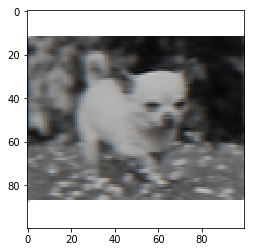

In [0]:
plt.imshow(test_ie.reshape(100,100,-1))

In [0]:
#test_ie = clahe.apply(test_ie[0])
test_ie = cv2.equalizeHist(test_ie) 
test_ie = gaussian_filter(test_ie, sigma=4)

In [0]:
test_ie

In [0]:
# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(test_ie.reshape(100,100,-1),None)

# compute the descriptors with ORB
kp, des = orb.compute(test_ie.reshape(100,100,-1), kp)

In [0]:
test_clust = cls.predict(des)

In [0]:
def texture_im(image):
        # calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(image)

        # take the mean of it and return it
        ht_mean = textures.mean(axis=0)
        return ht_mean

In [0]:
test_text = texture_im(test_ie.reshape(100,100,-1))

In [0]:
vect = np.zeros(50)
        
dict_desc = collections.Counter(test_clust)
        
for k in range(vect.shape[0]):
            
    vect[k]= dict_desc[k]

In [0]:
test_sample = np.hstack((vect,test_text))

In [0]:
test_sample = scaler.transform(test_sample.reshape(1,-1))

In [0]:
def display(sample):
    
    proba_array = gs_mlp.predict_proba(test_sample)
    
    for i in range(0,5):
        
        print("Probability to be a {} is {} %".format(le.classes_[i],np.float128(proba_array[0][i]*100)) )

In [0]:
display(test_sample)

Probability to be a Afghan_hound is 68.20347979573738 %
Probability to be a Chihuahua is 16.016113967210817 %
Probability to be a Maltese_dog is 6.226466598910978 %
Probability to be a Pekinese is 3.1769618817082907 %
Probability to be a Shih-Tzu is 6.376977756432546 %
